In [1]:
import pandas as pd
import glob

# a = pd.read_csv('./data/coin_Bitcoin.csv')
# a

csv_files = glob.glob('./data/coin_*.csv')
dfs = [pd.read_csv(f) for f in csv_files]
all_coins = pd.concat(dfs, ignore_index=True)
all_coins = pd.DataFrame(all_coins)
all_coins[['High', 'Low', 'Open', 'Close', 'Volume', 'Marketcap']] = all_coins[['High', 'Low', 'Open', 'Close', 'Volume', 'Marketcap']].astype(float)
binance_coin_df = all_coins[all_coins['Name'] == 'Bitcoin']
binance_coin_df
# all_coins

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
1717,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09
1718,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09
1719,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09
1720,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09
1721,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09
...,...,...,...,...,...,...,...,...,...,...
4703,2987,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11
4704,2988,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11
4705,2989,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11
4706,2990,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11


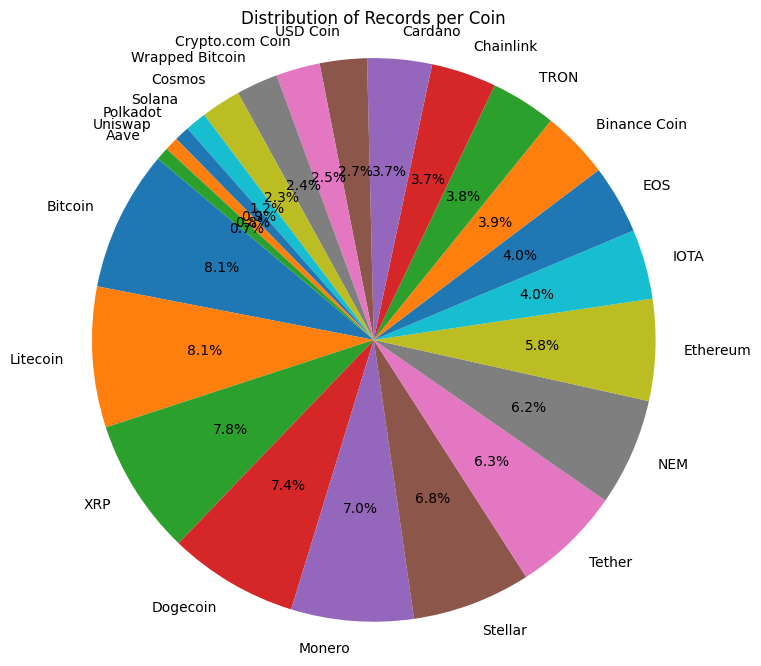

In [2]:
import matplotlib.pyplot as plt

coin_counts = all_coins['Name'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(coin_counts, labels=coin_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Records per Coin')
plt.axis('equal')
plt.show()

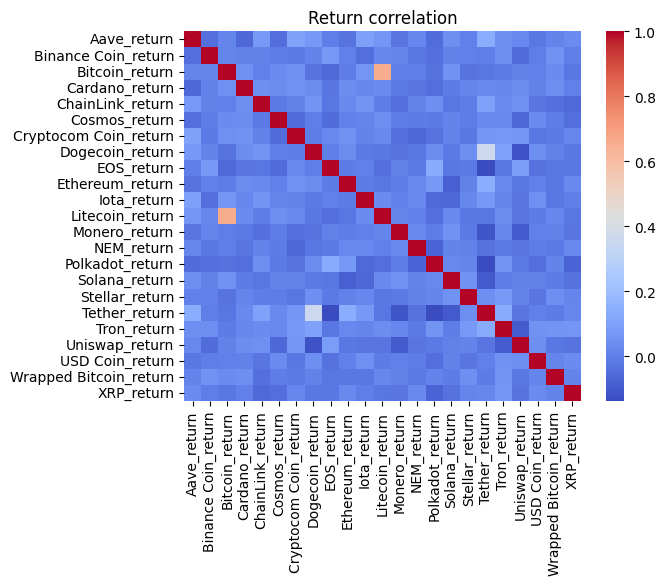

In [3]:
import seaborn as sn

# Create a dictionary mapping coin names to DataFrames
dataframes = {}
for f, df in zip(csv_files, dfs):
    # Extract coin name from file path, e.g., './data/coin_Bitcoin.csv' -> 'Bitcoin'
    coin_name = f.split('coin_')[1].split('.csv')[0].replace('Coin', ' Coin').replace('Wrapped', 'Wrapped ').replace('Crypto.com', 'Crypto.com ')
    coin_name = coin_name.replace('_', ' ').replace('  ', ' ').strip()
    dataframes[coin_name] = df

dic_returns = {}

# Compute returns for each DataFrame and store in dic_returns
for dataset_name, dataset_df in dataframes.items():
    # Calculate daily return as percentage change of 'Close' price
    dataset_df['return'] = dataset_df['Close'].pct_change()
    dic_returns_key = f'{dataset_name}_return'
    dic_returns[dic_returns_key] = dataset_df['return']

# CORRELATION WITH RETURN
return_corr_matrix = pd.DataFrame(dic_returns).shift(-1).corr()
sn.heatmap(return_corr_matrix, annot=False, cmap='coolwarm')
plt.title('Return correlation')
plt.show()

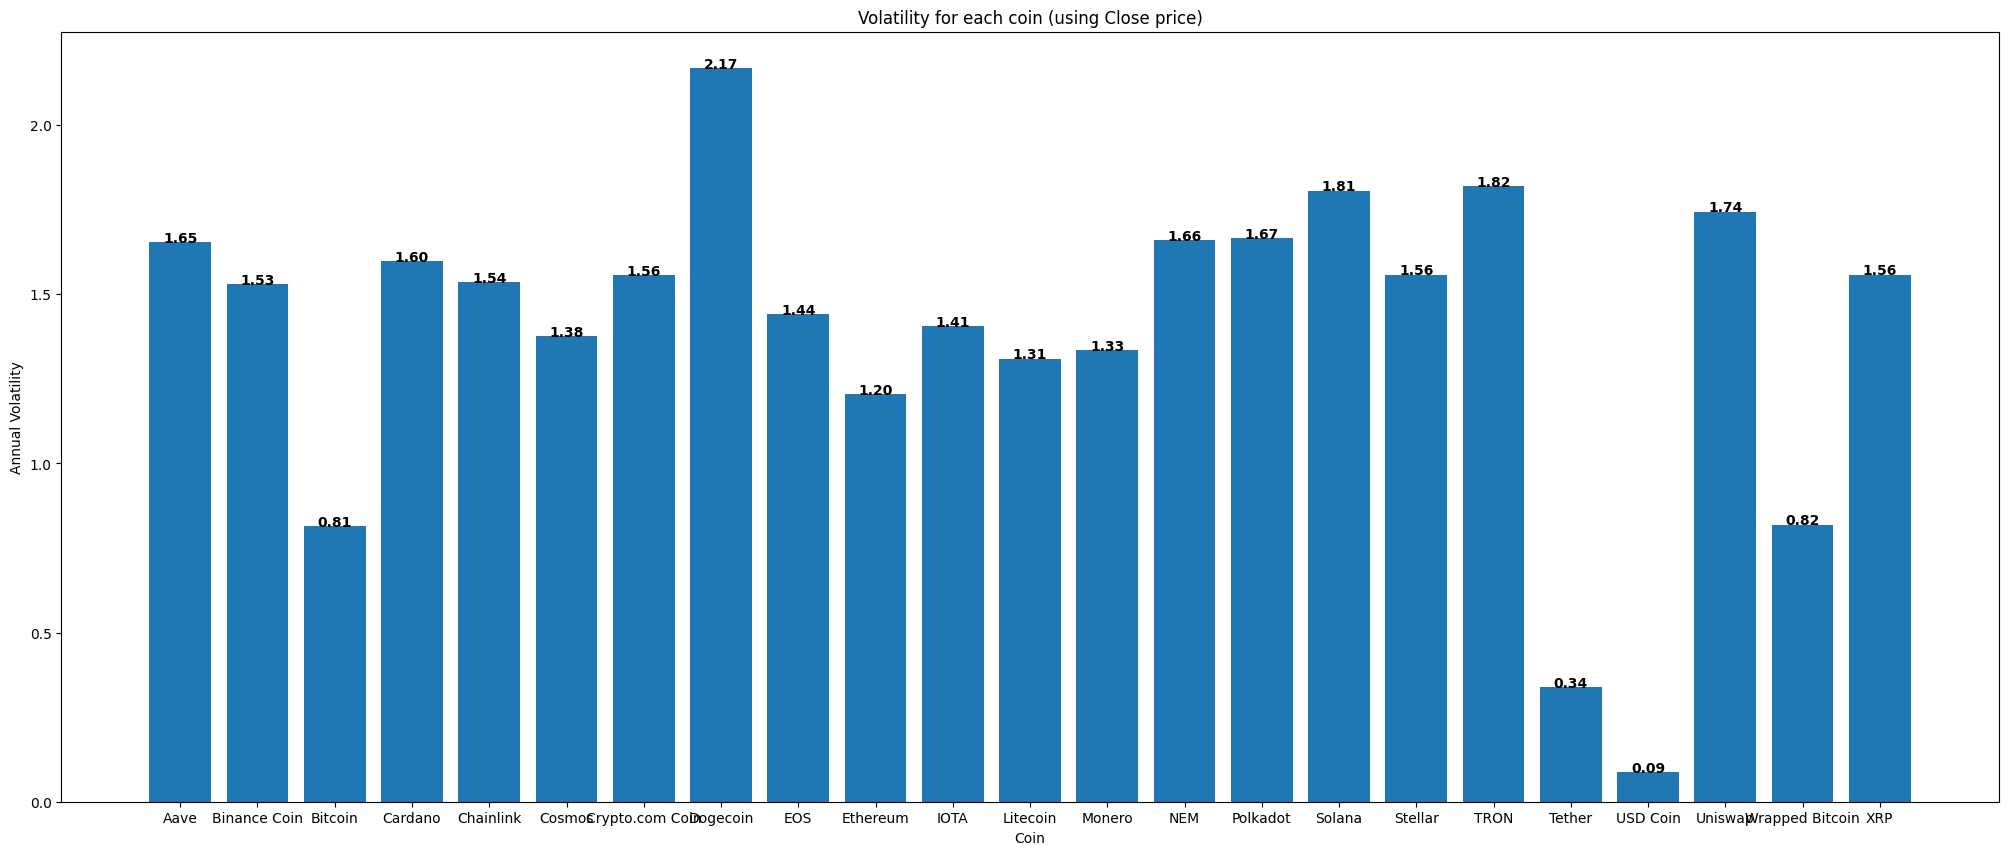

In [4]:
# Calculate daily returns from Close prices if not already present
if 'return' not in all_coins.columns:
    all_coins['return'] = all_coins.groupby('Name')['Close'].pct_change()

# Calculate annualized volatility for each coin using Close price returns
volatility = all_coins.groupby('Name')['return'].agg('std') * (365 ** 0.5)
volatility = volatility.dropna()

plt.figure(figsize=(25, 10))
plt.bar(volatility.index, volatility.values)
plt.title('Volatility for each coin (using Close price)')
plt.xlabel('Coin')
plt.ylabel('Annual Volatility')
for i, v in enumerate(volatility.values):
    plt.text(i, v, "{:.2f}".format(v), ha='center', weight='bold')
plt.show()


In [5]:
from sklearn.model_selection import train_test_split
X = all_coins[['High', 'Low', 'Open', 'Close', 'Volume', 'Marketcap']].values
y = all_coins['Name'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten
from sklearn.preprocessing import LabelEncoder

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
num_classes = len(le.classes_)

# Build CNN model for classification
model = Sequential([
    
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
epochs = 10
batch_size = 32
history = model.fit(
    X_train, y_train_enc,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test_enc)
)

c:\Users\ADMIN\OneDrive\Tài liệu\Vidu\mindx_python\csi\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 5, 64)          │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 23)             │         1,495 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,231 (86.84 KB)

 Trainable params: 22,231 (86.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
928/928 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1137 - loss: 134907632.0000 - val_accuracy: 0.1122 - val_loss: 118879672.0000
Epoch 2/10
928/928 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1110 - loss: 29365076.0000 - val_accuracy: 0.0798 - val_loss: 511.0873
Epoch 3/10
928/928 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0775 - loss: 63.2375 - val_accuracy: 0.0897 - val_loss: 4.3407
Epoch 4/10
928/928 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0884 - loss: 4.3342 - val_accuracy: 0.0902 - val_loss: 4.0774
Epoch 5/10
928/928 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0901 - loss: 4.1473 - val_accuracy: 0.0906 - val_loss: 3.8420
Epoch 6/10
928/928 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0900 - loss: 3.7202 - val_accuracy: 0.0907 - val_loss: 3.6762
Epoch 7/10
928/928 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0891 - loss: 3.5266 - val_accuracy: 0.0913 - val_loss: 3.4062
Epoch 8/10
928/928 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0924 - loss:

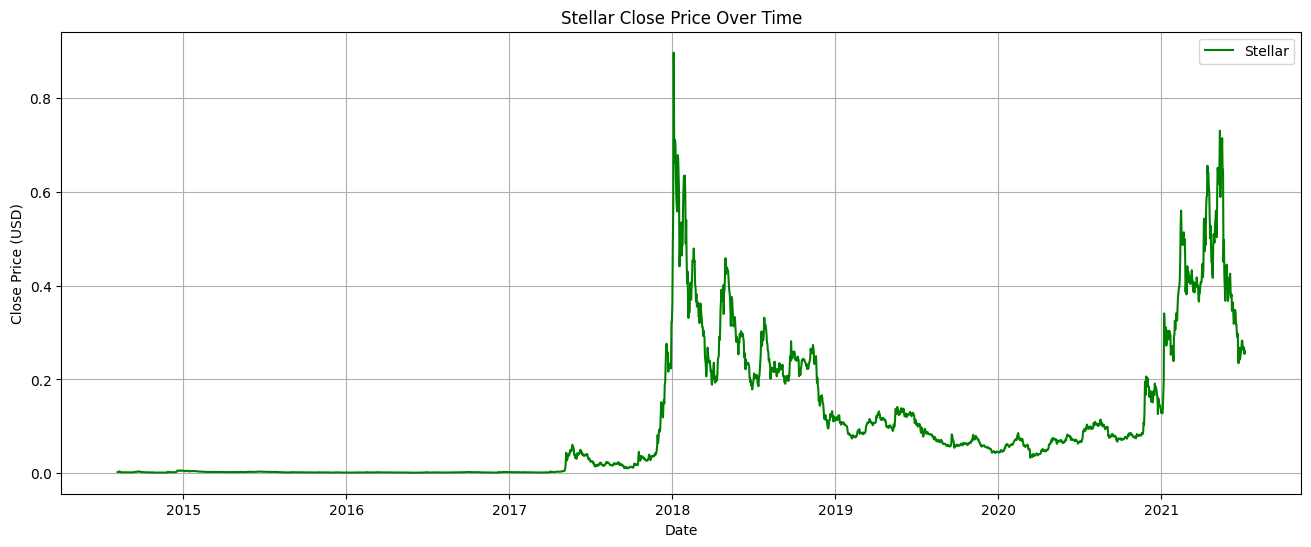

In [13]:
a = 'Stellar'  # Replace with the desired coin name
coin_df = all_coins[all_coins['Name'] == a]
coin_df = pd.DataFrame(coin_df)

plt.figure(figsize=(16, 6))
plt.plot(pd.to_datetime(coin_df['Date']), coin_df['Close'], label=a, color='green')
plt.title(f'{a} Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Filter test samples for the selected coin
coin_idx = (y_test == a)  # Replace 'AveCoin' with the desired coin name
X_coin = X_test[coin_idx]

# Predict class probabilities for the selected coin samples
coin_pred_probs = model.predict(X_coin)
coin_pred_classes = coin_pred_probs.argmax(axis=1)
coin_pred_labels = le.inverse_transform(coin_pred_classes)

# Show the corresponding Close prices for the selected coin test samples
coin_close_prices = X_coin[:, 3]
# Convert Close prices to USD format and print
coin_close_prices_usd = ["${:,.2f}".format(price) for price in coin_close_prices]
print(f"Close prices for {a} test samples (USD):", max(coin_close_prices_usd))




16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Close prices for Stellar test samples (USD): $0.66


In [15]:
# Nếu bạn có mảng giá dự đoán coin_predicted_close_prices (kiểu float)
import numpy as np
price_diff_pred = np.diff(coin_close_prices)
trend_pred = np.where(price_diff_pred > 0, 1, np.where(price_diff_pred < 0, -1, 0))
num_up_pred = np.sum(trend_pred == 1)
num_down_pred = np.sum(trend_pred == -1)
num_same_pred = np.sum(trend_pred == 0)
if price_diff_pred[-1] > 0:
    print("tang")
elif price_diff_pred[-1] < 0:
    print("giam")
else:
    print("khong doi")


tang


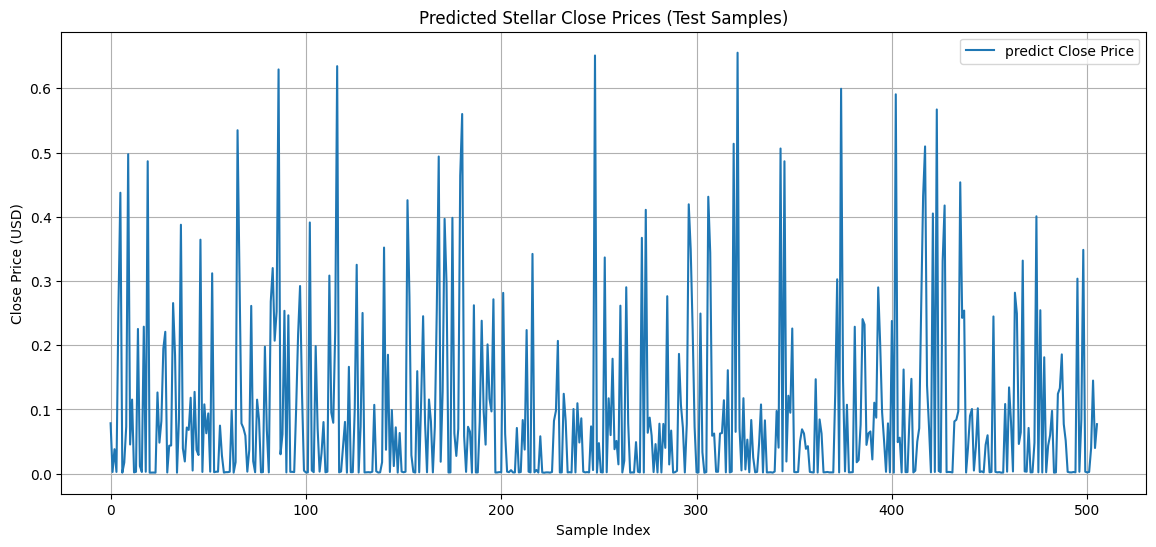

In [16]:
plt.figure(figsize=(14, 6))
plt.plot(range(len(coin_close_prices)), coin_close_prices, label='predict Close Price')
plt.title(f'Predicted {a} Close Prices (Test Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

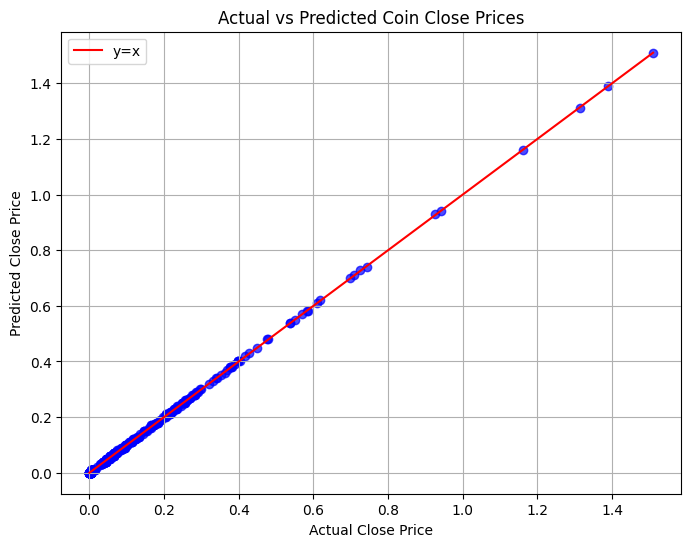

In [11]:
plt.figure(figsize=(8, 6))
# Convert coin_close_prices_usd to float for plotting if needed
import re
coin_close_prices_usd_float = [float(re.sub(r'[$,]', '', s)) for s in coin_close_prices_usd]

plt.scatter(coin_close_prices, coin_close_prices_usd_float, color='blue', alpha=0.7)
max_val = max(max(coin_close_prices), max(coin_close_prices_usd_float))
plt.plot([0, max_val], [0, max_val], color='red', linestyle='-', label='y=x')
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.title('Actual vs Predicted Coin Close Prices')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
asd = list(all_coins['Name'])
asd = list(dict.fromkeys(asd))
for coins in asd:
    # Filter test samples for the selected coin
    coin_idx = (y_test == coins)  # Replace 'AveCoin' with the desired coin name
    X_coin = X_test[coin_idx]

    # Predict class probabilities for the selected coin samples
    coin_pred_probs_all_coins = model.predict(X_coin)
    coin_pred_classes_all_coin = coin_pred_probs_all_coins.argmax(axis=1)
    coin_pred_labels_all_coin = le.inverse_transform(coin_pred_classes_all_coin)

    # Show the corresponding Close prices for the selected coin test samples
    coin_close_prices_all_coin = X_coin[:, 3]
    # Convert Close prices to USD format and print
    coin_close_prices_all_coin_usd = ["${:,.2f}".format(price) for price in coin_close_prices_all_coin]
    print(f"Close prices for {coins} test samples (USD):", max(coin_close_prices_all_coin_usd))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Close prices for Aave test samples (USD): $91.68
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Close prices for Binance Coin test samples (USD): $9.94
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Close prices for Bitcoin test samples (USD): $999.18
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Close prices for Cardano test samples (USD): $2.17
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Close prices for Chainlink test samples (USD): $9.85
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Close prices for Cosmos test samples (USD): $9.49
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Close prices for Crypto.com Coin test samples (USD): $0.25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Close prices for Dogecoin test samples (USD): $0.51
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Close prices for EOS test samples (USD): $9.84
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Close prices for Ethereum test samples (USD): $975.51
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Close prices for IOTA test samples (USD): $5.01
